# Hawai'i Island Hotels: TripAdvisor Review Topic Modeling

#### *John E. Sukup III, Principal Consultant, Expected X*

Visitor reviews of vacation lodging are an important source of information for hotel and resort management. A traditional approach to gathering this data would be via surveys, comment cards, or even phone transcriptions to customer service call centers. A modern approach to gleaning insights from visitors can be accomplished via natural language processing (NLP) of reviews left on websites such as TripAdvisor. 

With this approach, visitors are in an environment where they can openly share their opinions in a natural way without the interference of a researcher. They are allowed to freely express their opinions in their own words without prompting as done in a survey. Biases usually introduced by the subjectivity of a researcher are all but eliminated, however it should be noted that visitors' reviews could be influenced by reading other reviews prior to writing their own. Also, considerations should be made that visitors providing reviews to websites like TripAdvisor are self-selecting so an argument about how representative the sample is could be made.

Nevertheless, I believe the positives outweigh the negatives and that meaningful, if not actionable, insights can be extracted from visitor hotel reviews. The goal of this study will be to learn what underlying themes are reoccuring in positive and negative reviews using Latent Dirichlet Allocation (LDA) for Topic Modeling. 

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.utils import simple_preprocess
%matplotlib inline
warnings.filterwarnings('ignore')

C:\analyticsdev\Anaconda\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Scraping TripAdvisor Reviews

TripAdvisor offers and [API](https://developer-tripadvisor.com/content-api/) but does not allow the API to be called for gathering hotel reviews for research purposes. This means one needs to resort to web scraping in order to gather reviews and metadata relating to them.

While a number of web scraping tools exist such as [Octoparse](http://www.octoparse.com/) I chose to stay within the Python environment for all stages of this project. Python also has a number of web scraping packages. I chose Scrapy due to its relatively easy to understand coding structure.

Scrapy has an extensive number of features for production-level web scraping but for this research only a base scraper was needed.

In [ ]:
import scrapy
from tripadvisor.items import TripadvisorItem

class TrSpider(scrapy.Spider):
    name = 'trspider'
    start_urls = [
            'https://www.tripadvisor.com/Hotels-g29217-Island_of_Hawaii_Hawaii-Hotels.html'
            ]

    def parse(self, response):
        for href in response.xpath('//div[@class="listing_title"]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_hotel)

        next_page = response.xpath('//div[@class="unified pagination standard_pagination"]/child::*[2][self::a]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse)

    def parse_hotel(self, response):
        for href in response.xpath('//div[starts-with(@class,"quote")]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_review)


        next_page = response.xpath('//link[@rel="next"]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse_hotel)

    def parse_review(self, response):
        item = TripadvisorItem()
        item['headline'] = response.xpath('translate(//div[@class="quote"]/text(),"!"," ")').extract()[0][1:-1]
        item['review'] = response.xpath('translate(//div[@class="entry"]/p,"\n"," ")').extract()[0]
        item['bubbles'] = response.xpath('//span[contains(@class,"ui_bubble_rating")]/@alt').extract()[0]
        item['date'] = response.xpath('normalize-space(//span[contains(@class,"ratingDate")]/@content)').extract()[0]
        item['hotel'] = response.xpath('normalize-space(//span[@class="altHeadInline"]/a/text())').extract()[0]
        return item

Most of the above code was reworked from that found [here](https://github.com/monkeylearn/hotel-review-analysis) from the team at MonkeyLearn. At the time of writing, the original code no longer appeared to work due apparent changes in TripAdvisor's webpage design and had to be tweaked in order to run correctly.

The web scraper (or "spider") begins with a base URL. In this case I started at the main page for Island of Hawai'i hotels. The Python class "TrSpider" contains three functions for parsing reviews and following links to navigate multiple pages of reviews. Ultimately, the scraper creates a CSV file containing the following features:

* Review headline
* Review text
* Bubble rating
* Review date
* Hotel/Resort name

In [2]:
df = pd.read_csv('bihotels.csv', dtype={'bubbles':'category','hotel':'category','review':'str'}, parse_dates=[1])
df.dropna(inplace=True)
df['rating'] = np.where((df['bubbles'] == '5 of 5 bubbles') | (df['bubbles'] == '4 of 5 bubbles'), 'pos', 'neg')
df = df.groupby('hotel').filter(lambda x: len(x) > 100)
df['hotel'] = df['hotel'].cat.remove_unused_categories()
df.head()

,bubbles,date,headline,hotel,review,rating
0,5 of 5 bubbles,2017-07-19,Satisfied Beyond our expectations,"Fairmont Orchid, Hawaii",From the moment we arrived at the Fairmont or...,pos
1,5 of 5 bubbles,2017-07-19,Honeymoon at the Fairmont,"Fairmont Orchid, Hawaii",We went there for our honeymoon and were wowe...,pos
2,3 of 5 bubbles,2017-07-19,Travelguy,"Fairmont Orchid, Hawaii",Hotel is in a lovely remote location and is a...,neg
3,4 of 5 bubbles,2017-06-29,Met our expectations,Wyndham Mauna Loa Village,"We stayed here for 7 nights, June 18-25, 2017...",pos
4,5 of 5 bubbles,2017-06-27,Great hotel with amazing views,"Fairmont Orchid, Hawaii",My husband and I stayed here at the beginning...,pos


Some general data clensing is performed to remove records with missing values and dropping hotels with fewer than 100 reviews. This leaves me with 40,806 reviews to work with from over 14 years (4/6/2003 - 7/20/2017).

Additional, I created a feature, "rating," combining 4 and 5 bubble reviews (positive) and 1, 2, and 3 bubble reviews (negative) intended to simplify the definition of "positive review" from "negative review." 

One observation to note is the class imbalance introduced by adding this arbitrary split. If I were preparing a classification model I'd want to address this. No other logical splits would appear to remedy this either. An alternative approach perhaps would be to simulate additional reviews for the low scoring reviews (see a method described [here]('http://datamining.rutgers.edu/publication/ipm2010.pdf')). I will simply build an LDA model for *both* positive and negative reviews since their individual sample sizes should be sufficient.

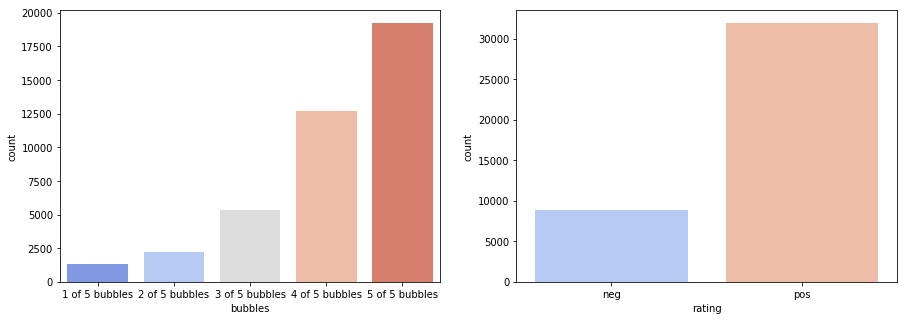

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
sns.countplot(df['bubbles'], ax=axs[0], palette='coolwarm')
sns.countplot(df['rating'], ax=axs[1], palette='coolwarm', order=['neg','pos'])

## Preperation for Topic Modeling

While Python has an abundance of add-on packages similar to R, my choice is the *gensim* package (with a little help from the NLTK package, too) since it is built specifically for the purpose of Topic Modeling using the LDA algorithm. It also is scalable for large NLP processing jobs and can be multi-threaded to take advantage of multiple compute cores. But first I should describe both Topic Modeling and LDA in overtly simple terms so as not to get bogged down in the underlying complexities:

* **Topic Modeling**: Say you have an encyclopedia. Each chapter covers one "topic." If you were to examine each chapter word-for-word, you'd discover that some words appear more often than others in one chapter compared to another (i.e. "leaves"/"roots" would probably appear much more frequently in a chapter about "Trees" but less frequently, if at all, in a chapter about "Automobiles"). Topic Modeling generates sets of commonly co-occuring words found within documents. It's up to the analyst to determine what the *latent* structure is within the word sets and thus what topic they best represent. Since our "encyclopedia" in this case are just the sets of positive and negative reviews, we don't know what the chapters/topics are yet. Topic modeling will unveil those through our interpretations.


* **LDA**: LDA is probably the most common algorithm for discovering these underlying topics. We choose a number of topics we want it to find in our encyclopedia (this is more of an analytics *art* than *science*). LDA then goes through word-by-word and assigns each word to a random topic. This isn't very helpful initially so we need to find the *best* topic for each word. LDA does this by calculating the proportion of words in the encyclopedia that are currently assigned to a topic and the proportion of assignments to a topic within the encyclopedia for a given word. We essentially want to group words together that have a high probability of co-occuring in a specific topic. LDA iteratively reassigning words to new topics until words stop moving around as much ("convergence") because we've begun to find the best sets for them to belong in. We are left with word sets for each topic (remember *we* chose the number of topics to find, not LDA), the probability of each occuring within a topic, and the probability of a topic occuring within the whole encyclopedia.

### NLP Transformations

Before I can apply LDA to our set of reviews, I need to perform a few NLP preperation steps to get the text in the correct form for analysis. Here are the three I'll perform below:

* Remove **stopwords** from our reviews, or, words with little intrinsic value to our Topic Model. This includes words like "and," "the," "or," etc. I am left with only meaningful words for LDA to iterate through. So an example sentence like *"The rooms were very spacious and comfortable"* would become *"rooms spacious comfortable."* (NOTE: words that are considered stopwords can vary by source.)


* Convert the words to **lowercase.** This is so we don't consider words at the beginning of sentences as different from those within a sentence (e.g. "Beach" and "beach").


* **Tokenize** our words, or, transform reviews from blocks of text into vectors of individual words. So now instead of our sentence I'd have each individual word on their own: *"room," "very," "space," "comfort."* Each word is now called a "token."

There are other data cleaning transformations I could perform in NLP like **stemming** and **lemmatization** but they might not be well suited for this purpose but I will explore them later depending on how our topics/word sets look following LDA.

In [4]:
def tokenizer(reviews):
    return [[token for token in simple_preprocess(review) if token not in STOPWORDS] 
            for review in reviews]

The *gensim* package contains the method *simple_preprocess* which applies all three of the above mentioned NLP preprocessing techniques and leaves me with a prepared list for LDA. I'll do this for both positive and negative reviews.

In [5]:
pos = df[df['rating'] == 'pos']
neg = df[df['rating'] == 'neg']
pos_reviews = (pos['review']).tolist()
neg_reviews = (neg['review']).tolist()
pos_review_tokens = tokenizer(pos_reviews)
neg_review_tokens = tokenizer(neg_reviews)

### Bag-of-Words

With our list of tokens for each review, I now need to turn them into something I can process with LDA. The first step is to create a dictionary for our tokens. This isn't a dictionary in the traditional sense of the word, but rather a list containing each unique token in our collection of reviews with a unique integer ID assigned to it.

In [6]:
pos_dic = corpora.Dictionary(pos_review_tokens)
pos_dic.filter_n_most_frequent(4)
neg_dic = corpora.Dictionary(neg_review_tokens)
neg_dic.filter_n_most_frequent(4)

Then I go back through our token vectors and count how many times each appears in a review. The end result is a tuple (Token ID, Frequency) for every unique token in each reviews.

In [7]:
pos_bow = [pos_dic.doc2bow(review) for review in pos_review_tokens]
neg_bow = [neg_dic.doc2bow(review) for review in neg_review_tokens]
pos_tokens = pd.DataFrame(list(pos_dic.token2id.items()), columns=['token','id'])
pos_dt = pd.DataFrame(pos_bow[0], columns=['id','freq'])
pos_dt.merge(pos_tokens)

,id,freq,token
0,0,1,moment
1,1,1,arrived
2,2,1,fairmont
3,3,1,orchid
4,4,1,treated
5,5,1,incredibly
6,6,2,member
7,7,1,encountered
8,8,1,beautiful
9,9,1,clean


The example above is a review with 37 unique tokens and their frequency within the given review. Most words appear only once, but others like "staff" and "property" appear two times. This process is performed across all reviews.

I am left with what is called a "bag-of-words" representation. A bag-of-words is just a numeric representation of unique word frequency across a collection (or "corpus") of texts. It doesn't account for any other linguistic features that might influence our topic model like part-of-speech (is the word a noun, verb, adjective?) or context (does "drive" mean "drive a vehicle" or "motivation?").

Unique word frequencies alone won't help me build a LDA topic model. I'll need to perform another transformation called "Term Frequency - Inverse Document Frequency," or TF-IDF.

In [8]:
pos_tfidf = models.TfidfModel(pos_bow, id2word=pos_dic)
neg_tfidf = models.TfidfModel(neg_bow, id2word=neg_dic)

In [9]:
neg_freq = {k: neg_tfidf.dfs.get(v) for v, k in neg_dic.id2token.items()}
sorted(neg_freq.items(), key=lambda x: x[1], reverse=True)

[]

In [10]:
pos_freq = {k: pos_tfidf.dfs.get(v) for v, k in pos_dic.id2token.items()}
sorted(pos_freq.items(), key=lambda x: x[1], reverse=True)

[]

In [11]:
pos_dic.id2token.items()

dict_items([])

### LDA

In [16]:
pos_lda = models.LdaModel(pos_bow, id2word=pos_dic, num_topics=3, chunksize=10000, passes=4, iterations=100)
pos_lda.show_topics(formatted=False)

[(0,
  [('nice', 0.010715318554323),
   ('stay', 0.0089187182943643844),
   ('clean', 0.0084357610019744067),
   ('good', 0.0079133698463915748),
   ('rooms', 0.0072932551445795829),
   ('night', 0.0071981160786825718),
   ('area', 0.0065826343367681858),
   ('pool', 0.0064615962952416835),
   ('place', 0.0061587348449357194),
   ('stayed', 0.0060768478688020466)]),
 (1,
  [('beach', 0.01702886930790818),
   ('resort', 0.013845659056530875),
   ('pool', 0.012189525326125134),
   ('ocean', 0.008703470510626558),
   ('nice', 0.0082752681033945175),
   ('good', 0.007960575054821336),
   ('food', 0.0072659713581628644),
   ('day', 0.0065215449132699534),
   ('kids', 0.006257866296300897),
   ('island', 0.0061482715093284599)]),
 (2,
  [('beach', 0.014137524024535265),
   ('resort', 0.012137244650710697),
   ('service', 0.011637524444420911),
   ('mauna', 0.0091302812535893167),
   ('stay', 0.0089521250619340222),
   ('seasons', 0.0078377857137161989),
   ('beautiful', 0.0074541888887023153

In [14]:
neg_lda = models.LdaModel(neg_bow, id2word=neg_dic, num_topics=3, chunksize=10000, passes=4, iterations=100)
neg_lda.show_topics(formatted=False)

[(0,
  [('night', 0.0079849722665773452),
   ('staff', 0.0077369225808560649),
   ('pool', 0.0068612636606136899),
   ('great', 0.0064278566151871157),
   ('view', 0.0063113463136322996),
   ('place', 0.0061562918669628604),
   ('like', 0.0060575353954311966),
   ('good', 0.0058646773285972939),
   ('day', 0.0056251754066972736),
   ('stayed', 0.0052178321798632358)]),
 (1,
  [('resort', 0.012705358256310929),
   ('ocean', 0.0098423563151825502),
   ('nice', 0.0068987525290066009),
   ('hilton', 0.0068450665852559898),
   ('view', 0.0064948362301701142),
   ('time', 0.0064565074708988184),
   ('pool', 0.006431593289282612),
   ('day', 0.0063042078114026222),
   ('beach', 0.006267685346002352),
   ('good', 0.0061408218572786763)]),
 (2,
  [('service', 0.0082982484383522896),
   ('beach', 0.0079432532475636457),
   ('good', 0.0077331119133226874),
   ('nice', 0.0075149210089646441),
   ('pool', 0.0068470485282220534),
   ('staff', 0.0066147045630844817),
   ('food', 0.0060905800420744359